<a href="https://colab.research.google.com/github/seunghee-lee/option/blob/main/ELS_Valuation_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ELS Valuation Practice

## 1 Stock ELS

#### ① KOSPI200이 기초자산인 ELS 평가

In [1]:
!pip install yfinance

In [2]:
!pip install --upgrade yfinance

In [3]:
import yfinance as yf
import seaborn as sns
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as npr
from pylab import mpl, plt
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
from datetime import datetime, date

In [4]:
# Set the start and end date
start_date = '2010-01-01'
end_date = '2025-07-05'

In [5]:
ks200 = yf.download('^KS200', start_date, end_date)

/tmp/ipython-input-5-738133549.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ks200 = yf.download('^KS200', start_date, end_date)
[*********************100%***********************]  1 of 1 completed


In [6]:
ks200.tail()

Price,Close,High,Low,Open,Volume
Ticker,^KS200,^KS200,^KS200,^KS200,^KS200
Date,,,,,
2025-06-30,414.600006,416.980011,413.170013,415.279999,141100000
2025-07-01,416.260010,416.260010,416.260010,416.260010,0
2025-07-02,414.429993,416.570007,408.589996,415.399994,157000000
2025-07-03,420.940002,420.940002,416.119995,418.309998,165600000
2025-07-04,412.739990,422.559998,412.299988,422.239990,159900000


In [7]:
ks200['Return']=np.log(ks200['Close']/ks200['Close'].shift(1))
ks200.tail()

Price,Close,High,Low,Open,Volume,Return
Ticker,^KS200,^KS200,^KS200,^KS200,^KS200,
Date,,,,,,
2025-06-30,414.600006,416.980011,413.170013,415.279999,141100000,0.004545
2025-07-01,416.260010,416.260010,416.260010,416.260010,0,0.003996
2025-07-02,414.429993,416.570007,408.589996,415.399994,157000000,-0.004406
2025-07-03,420.940002,420.940002,416.119995,418.309998,165600000,0.015586
2025-07-04,412.739990,422.559998,412.299988,422.239990,159900000,-0.019672


In [8]:
ks200['Mov_vol']=ks200['Return'].rolling(window=245).std()*math.sqrt(245)
ks200.tail()

Price,Close,High,Low,Open,Volume,Return,Mov_vol
Ticker,^KS200,^KS200,^KS200,^KS200,^KS200,,
Date,,,,,,,
2025-06-30,414.600006,416.980011,413.170013,415.279999,141100000,0.004545,0.229705
2025-07-01,416.260010,416.260010,416.260010,416.260010,0,0.003996,0.229707
2025-07-02,414.429993,416.570007,408.589996,415.399994,157000000,-0.004406,0.229619
2025-07-03,420.940002,420.940002,416.119995,418.309998,165600000,0.015586,0.230114
2025-07-04,412.739990,422.559998,412.299988,422.239990,159900000,-0.019672,0.230948


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

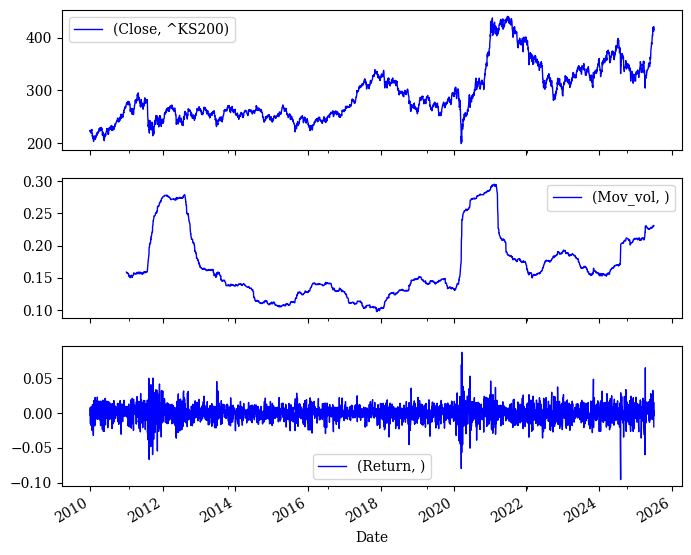

In [9]:
ks200[['Close','Mov_vol', 'Return']].plot(subplots=True, style='b', lw='1', figsize=(8,7))

In [10]:
n=10000    # 시뮬레이션 횟수
r=0.025    # 이자율, 3년 국고채 금리
vol=0.2231  # 변동성
n0=date.toordinal(date(2025,7,11))  # 최초 기준가격 결정일
n1=date.toordinal(date(2025,10,10))  # 1차 조기 상환일
n2=date.toordinal(date(2026,1,9))  # 2차 조기 상환일
n3=date.toordinal(date(2026,4,10))  # 3차 조기 상환일
n4=date.toordinal(date(2026,7,10))  # 4차 조기 상환일
n5=date.toordinal(date(2026,10,8))  # 5차 조기 상환일
n6=date.toordinal(date(2027,1,8))  # 6차 조기 상환일
n7=date.toordinal(date(2027,4,9))  # 7차 조기 상환일
n8=date.toordinal(date(2027,7,9))  # 8차 조기 상환일
n9=date.toordinal(date(2027,10,7))  # 9차 조기 상환일
n10=date.toordinal(date(2028,1,11))  # 10차 조기 상환일
n11=date.toordinal(date(2028,4,11))  # 11차 조기 상환일
n12=date.toordinal(date(2028,7,11))  # 만기 상환일

check_day=np.array([n1-n0, n2-n0, n3-n0, n4-n0, n5-n0, n6-n0, n7-n0, n8-n0, n9-n0, n10-n0, n11-n0, n12-n0])
oneyear=365; tot_date=n12-n0
dt=1/oneyear
S=np.zeros([tot_date+1, 1])
S[0]=100.0  # 기초자산 초기값
strike_price=np.array([0.95, 0.95, 0.90, 0.90, 0.85, 0.85, 0.85, 0.85, 0.80, 0.80, 0.75, 0.70])*S[0]  # 조기 행사가격
repay_n=len(strike_price) # 조기상환 횟수

early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수

coupon_rate=np.array([0.0125, 0.025, 0.0375, 0.05, 0.0625, 0.075, 0.0875, 0.10, 0.1125, 0.1250, 0.1375, 0.15])  # 조기 상환시 쿠폰 이자율
payment=np.zeros([repay_n, 1])
facevalue=10000  # 액면금액
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가
kib=0.50*S[0]; dummy=0.15  # 낙인 배리어, 더미 이자율

#### GBM

In [11]:
for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [12]:
for i in range(n):
    z=np.random.normal(0, 1, size=[tot_date,1])  # 만기상환일 만큼의 난수 생성
    for j in range(tot_date):
        S[j+1]=S[j]*np.exp((r-0.5*vol**2)*dt+vol*np.sqrt(dt)*z[j])  # 임의의 주가 경로 생성
    S_checkday=S[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if S_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(S) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*(S[-1]/S[0])
           lose_count += 1
    tot_payoff=tot_payoff+payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

10153.947081358268


In [13]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 6723, 발생빈도 : 67.23 %
2차 : 968, 발생빈도 : 9.68 %
3차 : 707, 발생빈도 : 7.07 %
4차 : 277, 발생빈도 : 2.77 %
5차 : 304, 발생빈도 : 3.04 %
6차 : 130, 발생빈도 : 1.30 %
7차 : 88, 발생빈도 : 0.88 %
8차 : 64, 발생빈도 : 0.64 %
9차 : 103, 발생빈도 : 1.03 %
10차 : 57, 발생빈도 : 0.57 %
11차 : 68, 발생빈도 : 0.68 %
12차 : 459, 발생빈도 : 4.59 %
만기상환 발생횟수 : 19, 발생빈도 : 0.19 %
만기손실 발생횟수 : 33, 발생빈도 : 0.33 %


/tmp/ipython-input-13-2353948544.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


#### Jump Diffusion Model

In [14]:
lamb = 2.4
mu = -0.055
delta = 0.24

In [15]:
rj = lamb * (math.exp(mu + 0.5 * delta ** 2) - 1)

In [16]:
dt=1/oneyear
S=np.zeros([tot_date+1, 1])
S[0]=100.0  # 기초자산 초기값

early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수

payment=np.zeros([repay_n, 1])
facevalue=10000  # 액면금액
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가

for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [17]:
for i in range(n):
    z=np.random.normal(0, 1, size=[tot_date,1])  # 만기상환일 만큼의 난수 생성
    sn1 = npr.standard_normal(tot_date)
    poi = npr.poisson(lamb * dt, tot_date)
    for j in range(tot_date):
        S[j+1]=S[j]*np.exp((r-rj-0.5*vol**2)*dt+vol*np.sqrt(dt)*z[j] + (np.exp(mu + delta * sn1[j]) - 1) * poi[j])  # 임의의 주가 경로 생성
    S_checkday=S[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if S_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(S) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*(S[-1]/S[0])
           lose_count += 1
    tot_payoff=tot_payoff+payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

9894.522059370289


In [18]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 6275, 발생빈도 : 62.75 %
2차 : 973, 발생빈도 : 9.73 %
3차 : 615, 발생빈도 : 6.15 %
4차 : 289, 발생빈도 : 2.89 %
5차 : 254, 발생빈도 : 2.54 %
6차 : 156, 발생빈도 : 1.56 %
7차 : 133, 발생빈도 : 1.33 %
8차 : 89, 발생빈도 : 0.89 %
9차 : 125, 발생빈도 : 1.25 %
10차 : 77, 발생빈도 : 0.77 %
11차 : 84, 발생빈도 : 0.84 %
12차 : 457, 발생빈도 : 4.57 %
만기상환 발생횟수 : 15, 발생빈도 : 0.15 %
만기손실 발생횟수 : 458, 발생빈도 : 4.58 %


/tmp/ipython-input-18-2353948544.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


#### FDM

In [19]:
def thomas(alpha, beta, gamma, f):
    n=len(f)
    v=np.zeros(n)
    [aa, dd, cc, bb]=map(np.array,[alpha, beta, gamma, f])
    for i in range(1, n):
        mult=aa[i]/dd[i-1]
        dd[i]=dd[i]-mult*cc[i-1]
        bb[i]=bb[i]-mult*bb[i-1]
    v[n-1]=bb[n-1]/dd[n-1]
    for i in range(n-2, -1, -1):
        v[i]=(bb[i]-cc[i]*v[i+1])/dd[i]
    return v

In [20]:
facevalue=10000; R=300; volatility=0.2231
r=0.025; Nx=301; h=R/Nx; x0=100
x=np.linspace(0, R, Nx); T=3
Nt=360*T; dt=T/Nt
u=np.zeros((Nx, Nt+1)); ku=np.zeros((Nx, Nt+1))
coupon_rate=np.array([0.15, 0.1375, 0.125, 0.1125, 0.10, 0.0875, 0.075, 0.0625, 0.05, 0.0375, 0.025, 0.0125])
strike_price=np.array([0.70, 0.75, 0.80, 0.80, 0.85, 0.85, 0.85, 0.85, 0.90, 0.90, 0.95, 0.95])
step=np.array([np.rint(Nt/12), np.rint(2*Nt/12), np.rint(3*Nt/12), np.rint(4*Nt/12), np.rint(5*Nt/12), np.rint(6*Nt/12), np.rint(7*Nt/12), np.rint(8*Nt/12), np.rint(9*Nt/12), np.rint(10*Nt/12), np.rint(11*Nt/12), Nt+1])
dummy=0.15; kib=0.50

In [21]:
for i in range (0,Nx):
    if (x[i]<kib*x0):
        u[i,0]=x[i]/x0*facevalue
        ku[i,0]=x[i]/x0*facevalue
    elif (x[i]<strike_price[0]*x0):
        u[i,0]=facevalue*(1+dummy)
        ku[i,0]=x[i]/x0*facevalue
    else:
        u[i,0]=facevalue*(1+coupon_rate[0])
        ku[i,0]=facevalue*(1+coupon_rate[0])
[a,d,c,b]=map(np.zeros, [Nx, Nx, Nx, Nx])
a[:]=r*x/(2*h)-(volatility*x)**2/(2*h**2)
d[:]=(volatility*x)**2/(h**2)+r+(1/dt)
c[:]=-r*x/(2*h)-(volatility*x)**2/(2*h**2)
a[Nx-1]=a[Nx-1]-c[Nx-1]; d[Nx-1]=d[Nx-1]+2*c[Nx-1]
tag=0

for n in range (0,Nt):
    if (n==step[tag]):
        s=np.min(np.where(x>=x0*strike_price[tag+1]))
        u[s:Nx+1,n]=facevalue*(1+coupon_rate[tag+1])
        ku[s:Nx+1,n]=facevalue*(1+coupon_rate[tag+1])
        tag=tag+1
    s=np.min(np.where(x>=x0*kib))
    u[0:s,n]=ku[0:s, n]
    b=u[:,n]/dt
    u[:,n+1]=thomas(a,d,c,b)
    b=ku[:,n]/dt
    ku[:,n+1]=thomas(a,d,c,b)

ii=np.where(x==100)
print('Price=%f'%(u[ii,Nt]))

Price=9979.421009


/tmp/ipython-input-21-1930937491.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Price=%f'%(u[ii,Nt]))


### 개별종목이 기초자산인 ELS 평가

In [22]:
!pip install yfinance

In [23]:
!pip install --upgrade yfinance

In [24]:
import yfinance as yf
import seaborn as sns
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import mpl, plt
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
from datetime import datetime, date

In [25]:
# Set the start and end date
start_date = '2010-01-01'
end_date = '2025-07-05'

In [26]:
Tesla = yf.download('TSLA', start_date, end_date)

/tmp/ipython-input-26-1284809003.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  Tesla = yf.download('TSLA', start_date, end_date)
[*********************100%***********************]  1 of 1 completed


In [27]:
Tesla.tail()

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2025-06-27,323.630005,329.339996,317.500000,324.510010,89067000
2025-06-30,317.660004,325.579987,316.600006,319.899994,76695100
2025-07-01,300.709991,305.890015,293.209991,298.459991,145085700
2025-07-02,315.649994,316.829987,303.820007,312.630005,119191500
2025-07-03,315.350006,318.450012,312.760010,317.989990,58042300


In [28]:
Tesla['Return']=np.log(Tesla['Close']/Tesla['Close'].shift(1))
Tesla.tail()

Price,Close,High,Low,Open,Volume,Return
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,
Date,,,,,,
2025-06-27,323.630005,329.339996,317.500000,324.510010,89067000,-0.006621
2025-06-30,317.660004,325.579987,316.600006,319.899994,76695100,-0.018619
2025-07-01,300.709991,305.890015,293.209991,298.459991,145085700,-0.054835
2025-07-02,315.649994,316.829987,303.820007,312.630005,119191500,0.048488
2025-07-03,315.350006,318.450012,312.760010,317.989990,58042300,-0.000951


In [29]:
Tesla['Mov_vol']=Tesla['Return'].rolling(window=245).std()*math.sqrt(245)
Tesla.tail()

Price,Close,High,Low,Open,Volume,Return,Mov_vol
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,,
Date,,,,,,,
2025-06-27,323.630005,329.339996,317.500000,324.510010,89067000,-0.006621,0.723138
2025-06-30,317.660004,325.579987,316.600006,319.899994,76695100,-0.018619,0.723389
2025-07-01,300.709991,305.890015,293.209991,298.459991,145085700,-0.054835,0.724647
2025-07-02,315.649994,316.829987,303.820007,312.630005,119191500,0.048488,0.726225
2025-07-03,315.350006,318.450012,312.760010,317.989990,58042300,-0.000951,0.720714


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

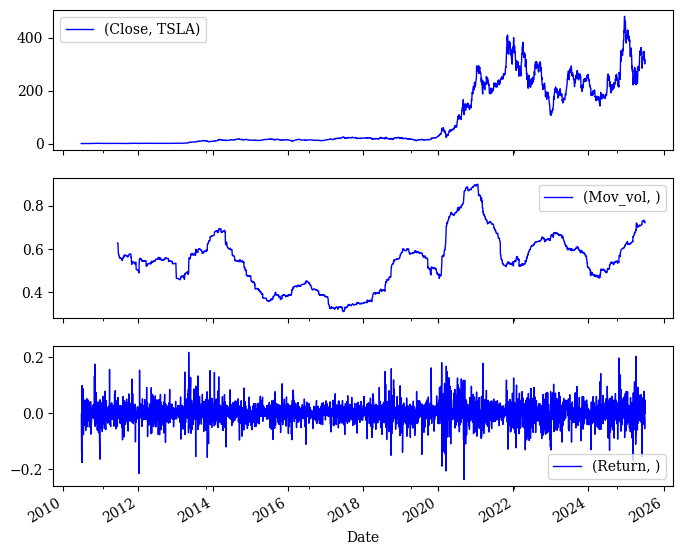

In [30]:
Tesla[['Close','Mov_vol', 'Return']].plot(subplots=True, style='b', lw='1', figsize=(8,7))

#### GBM

In [31]:
n=10000    # 시뮬레이션 횟수
r=0.025    # 이자율, 3년 국고채 금리
vol=0.7115  # 변동성
n0=date.toordinal(date(2025,7,8))  # 최초 기준가격 결정일
n1=date.toordinal(date(2025,11,10))  # 1차 조기 상환일
n2=date.toordinal(date(2025,12,8))  # 2차 조기 상환일
n3=date.toordinal(date(2026,1,8))  # 3차 조기 상환일
n4=date.toordinal(date(2026,2,9))  # 4차 조기 상환일
n5=date.toordinal(date(2026,3,9))  # 5차 조기 상환일
n6=date.toordinal(date(2026,4,8))  # 만기 상환일

check_day=np.array([n1-n0, n2-n0, n3-n0, n4-n0, n5-n0, n6-n0])
oneyear=365; tot_date=n6-n0
dt=1/oneyear
S=np.zeros([tot_date+1, 1])
S[0]=100.0  # 기초자산 초기값
strike_price=np.array([0.9, 0.9, 0.9, 0.9, 0.9, 0.8])*S[0]  # 조기 행사가격
repay_n=len(strike_price) # 조기상환 횟수

early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수

coupon_rate=np.array([0.071, 0.08875, 0.1065, 0.12425, 0.142, 0.15975])  # 조기 상환시 쿠폰 이자율
payment=np.zeros([repay_n, 1])
facevalue=10000  # 액면금액
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가
kib=0.0*S[0]; dummy=0.15975  # 낙인 배리어, 더미 이자율

In [32]:
for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [33]:
for i in range(n):
    z=np.random.normal(0, 1, size=[tot_date,1])  # 만기상환일 만큼의 난수 생성
    for j in range(tot_date):
        S[j+1]=S[j]*np.exp((r-0.5*vol**2)*dt+vol*np.sqrt(dt)*z[j])  # 임의의 주가 경로 생성
    S_checkday=S[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if S_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if S[-1] >= 80:  # 기준종목이 80% 이상 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 기준종목이 80% 미만 경우
           payoff[-1]=facevalue*S[-1]/100
           lose_count += 1
    tot_payoff=tot_payoff+payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

8974.270919910723


In [34]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 5355, 발생빈도 : 53.55 %
2차 : 611, 발생빈도 : 6.11 %
3차 : 384, 발생빈도 : 3.84 %
4차 : 277, 발생빈도 : 2.77 %
5차 : 171, 발생빈도 : 1.71 %
6차 : 339, 발생빈도 : 3.39 %
만기상환 발생횟수 : 0, 발생빈도 : 0.00 %
만기손실 발생횟수 : 2863, 발생빈도 : 28.63 %


/tmp/ipython-input-34-2353948544.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


#### Jump Diffusion Model

In [35]:
lamb = 1.2
mu = -0.077875
delta = 0.1

In [36]:
rj = lamb * (math.exp(mu + 0.5 * delta ** 2) - 1)

In [41]:
dt=1/oneyear
S=np.zeros([tot_date+1, 1])
S[0]=100.0  # 기초자산 초기값

early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수

payment=np.zeros([repay_n, 1])
facevalue=10000  # 액면금액
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가

for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [42]:
for i in range(n):
    z=np.random.normal(0, 1, size=[tot_date,1])  # 만기상환일 만큼의 난수 생성
    sn1 = npr.standard_normal(tot_date)
    poi = npr.poisson(lamb * dt, tot_date)
    for j in range(tot_date):
        S[j+1]=S[j]*np.exp((r-rj-0.5*vol**2)*dt+vol*np.sqrt(dt)*z[j] + (np.exp(mu + delta * sn1[j]) - 1) * poi[j])  # 임의의 주가 경로 생성
    S_checkday=S[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if S_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if S[-1] >= 80:  # 기준종목이 80% 이상 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 기준종목이 80% 미만 경우
           payoff[-1]=facevalue*S[-1]/100
           lose_count += 1
    tot_payoff=tot_payoff+payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

8904.711707609378


In [43]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 5262, 발생빈도 : 52.62 %
2차 : 609, 발생빈도 : 6.09 %
3차 : 389, 발생빈도 : 3.89 %
4차 : 243, 발생빈도 : 2.43 %
5차 : 180, 발생빈도 : 1.80 %
6차 : 323, 발생빈도 : 3.23 %
만기상환 발생횟수 : 0, 발생빈도 : 0.00 %
만기손실 발생횟수 : 2994, 발생빈도 : 29.94 %


/tmp/ipython-input-43-2353948544.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


## 2 Stocks ELS

In [45]:
import yfinance as yf
import seaborn as sns
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import mpl, plt
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
from datetime import datetime, date
from numpy.ma.core import correlate

In [46]:
# Set the start and end date
start_date = '2010-01-01'
end_date = '2025-07-05'

In [47]:
AMD = yf.download('AMD', start_date, end_date) # AMD
NVIDIA = yf.download('NVDA',start_date, end_date) # NVIDIA

/tmp/ipython-input-47-108861829.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  AMD = yf.download('AMD', start_date, end_date) # AMD
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-47-108861829.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  NVIDIA = yf.download('NVDA',start_date, end_date) # NVIDIA
[*********************100%***********************]  1 of 1 completed


In [48]:
eqt1 = pd.merge(AMD['Close'], NVIDIA['Close'], left_index=True, right_index=True, how='inner')
eqt1.columns=['AMD','NVIDIA']
eqt1.head()

,AMD,NVIDIA
Date,,
2010-01-04,9.70,0.423854
2010-01-05,9.71,0.430044
2010-01-06,9.57,0.432794
2010-01-07,9.47,0.424313
2010-01-08,9.43,0.425230


In [49]:
rtn= (np.log(eqt1) - np.log(eqt1.shift(1)) )*100
rtn.columns=['r_AMD','r_NVIDIA']
rtn.head()

,r_AMD,r_NVIDIA
Date,,
2010-01-04,NaN,NaN
2010-01-05,0.103042,1.449702
2010-01-06,-1.452311,0.637622
2010-01-07,-1.050424,-1.979213
2010-01-08,-0.423281,0.215864


In [50]:
eqt = pd.merge(eqt1,rtn,left_index=True, right_index=True, how='inner')
eqt.head()

,AMD,NVIDIA,r_AMD,r_NVIDIA
Date,,,,
2010-01-04,9.70,0.423854,NaN,NaN
2010-01-05,9.71,0.430044,0.103042,1.449702
2010-01-06,9.57,0.432794,-1.452311,0.637622
2010-01-07,9.47,0.424313,-1.050424,-1.979213
2010-01-08,9.43,0.425230,-0.423281,0.215864


In [51]:
eqt['Mov_vol_AMD']=eqt['r_AMD'].rolling(window=245).std()*math.sqrt(245)
eqt['Mov_vol_NVIDIA']=eqt['r_NVIDIA'].rolling(window=245).std()*math.sqrt(245)
eqt.tail()

,AMD,NVIDIA,r_AMD,r_NVIDIA,Mov_vol_AMD,Mov_vol_NVIDIA
Date,,,,,,
2025-06-27,143.809998,157.750000,0.090441,1.745733,52.787011,57.298111
2025-06-30,141.899994,157.990005,-1.337043,0.152027,52.652836,57.270469
2025-07-01,136.110001,153.300003,-4.165915,-3.013497,52.804193,57.304551
2025-07-02,138.520004,157.250000,1.755136,2.544009,52.691701,57.299781
2025-07-03,137.910004,159.339996,-0.441343,1.320337,52.683386,57.017407


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

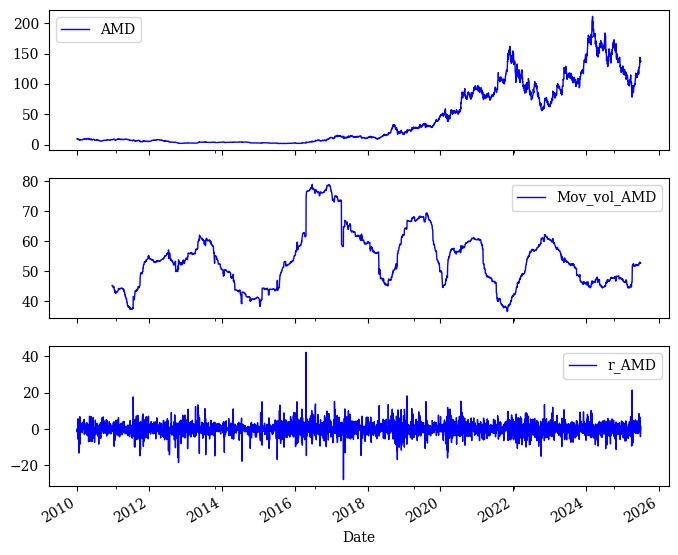

In [52]:
eqt[['AMD','Mov_vol_AMD', 'r_AMD']].plot(subplots=True, style='b', lw='1', figsize=(8,7))

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

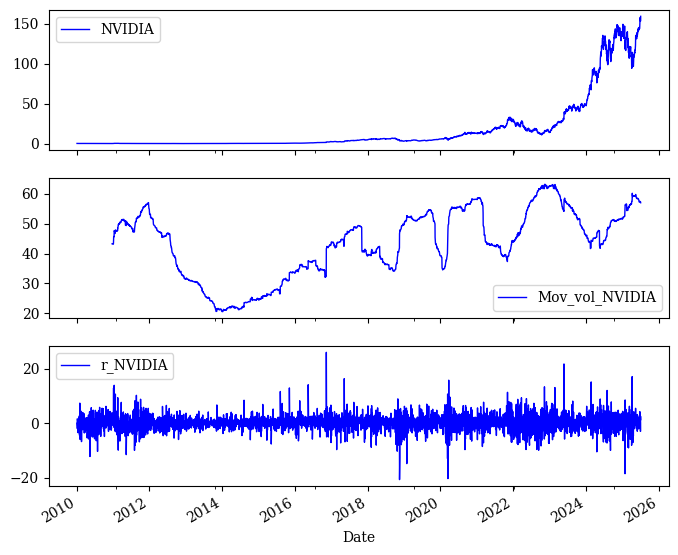

In [53]:
eqt[['NVIDIA','Mov_vol_NVIDIA', 'r_NVIDIA']].plot(subplots=True, style='b', lw='1', figsize=(8,7))

In [54]:
pr = eqt[['AMD','NVIDIA']]
pr.head()

,AMD,NVIDIA
Date,,
2010-01-04,9.70,0.423854
2010-01-05,9.71,0.430044
2010-01-06,9.57,0.432794
2010-01-07,9.47,0.424313
2010-01-08,9.43,0.425230


In [55]:
print(pr.describe())
print('skeness: ', pr.skew(axis=0))
print('kurtosis: ', pr.kurtosis(axis=0))

               AMD       NVIDIA
count  3899.000000  3899.000000
mean     43.077481    17.600204
std      50.329913    34.173387
min       1.620000     0.203560
25%       4.525000     0.422005
50%      12.300000     3.761541
75%      83.129997    15.288867
max     211.380005   159.339996
skeness:  AMD       1.080414
NVIDIA    2.562301
dtype: float64
kurtosis:  AMD      -0.086827
NVIDIA    5.561247
dtype: float64


In [56]:
pr.corr()

,AMD,NVIDIA
AMD,1.000000,0.785453
NVIDIA,0.785453,1.000000


In [57]:
rt = eqt[['r_AMD','r_NVIDIA']]
rt.head()

,r_AMD,r_NVIDIA
Date,,
2010-01-04,NaN,NaN
2010-01-05,0.103042,1.449702
2010-01-06,-1.452311,0.637622
2010-01-07,-1.050424,-1.979213
2010-01-08,-0.423281,0.215864


In [58]:
print(rt.describe())
print('skeness: ', rt.skew(axis=0))
print('kurtosis: ', rt.kurtosis(axis=0))

             r_AMD     r_NVIDIA
count  3898.000000  3898.000000
mean      0.068098     0.152114
std       3.486193     2.883618
min     -27.745556   -20.771171
25%      -1.696559    -1.259684
50%       0.000000     0.173818
75%       1.837674     1.619692
max      42.061696    26.087609
skeness:  r_AMD       0.276902
r_NVIDIA    0.174368
dtype: float64
kurtosis:  r_AMD       9.425466
r_NVIDIA    6.851295
dtype: float64


In [59]:
rt.corr()

,r_AMD,r_NVIDIA
r_AMD,1.000000,0.573064
r_NVIDIA,0.573064,1.000000


#### GBM

In [60]:
n=10000    # 시뮬레이션 횟수
r=0.025    # 이자율, 3년 국고채 금리
x_vol=0.5056; y_vol=0.5095  # 두 지수의 연간 변동성
n0=date.toordinal(date(2025,7,3))  # 최초 기준가격 결정일
n1=date.toordinal(date(2025,9,30))  # 1차 조기 상환일
n2=date.toordinal(date(2025,12,26))  # 2차 조기 상환일
n3=date.toordinal(date(2026,3,31))  # 3차 조기 상환일
n4=date.toordinal(date(2026,6,30))  # 4차 조기 상환일
n5=date.toordinal(date(2026,9,29))  # 5차 조기 상환일
n6=date.toordinal(date(2026,12,28))  # 6차 조기 상환일
n7=date.toordinal(date(2027,3,30))  # 7차 조기 상환일
n8=date.toordinal(date(2027,6,29))  # 8차 조기 상환일
n9=date.toordinal(date(2027,9,28))  # 9차 조기 상환일
n10=date.toordinal(date(2027,12,28))  # 10차 조기 상환일
n11=date.toordinal(date(2028,3,29))  # 11차 조기 상환일
n12=date.toordinal(date(2028,6,28))  # 만기 평가일
check_day=np.array([n1-n0, n2-n0, n3-n0, n4-n0, n5-n0, n6-n0, n7-n0, n8-n0, n9-n0, n10-n0, n11-n0, n12-n0])
rho=0.6786; corr=np.array([[1, rho], [rho, 1]])  # 상관계수
coupon_rate=np.array([0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.30, 0.33, 0.36])  # 조기 상환시 쿠폰 이자율
oneyear=365; tot_date=n12-n0; dt=1/oneyear
k=np.linalg.cholesky(corr)
S1=np.zeros([tot_date+1, 1])
S2=np.zeros([tot_date+1, 1])
S1[0]=100.0; S2[0]=100.0  # 기초자산 초기값
ratio_S1=S1[0]; ratio_S2=S2[0]
strike_price=np.array([0.85, 0.85, 0.85, 0.80, 0.75, 0.75, 0.75, 0.70, 0.65, 0.65, 0.65, 0.50])  # 조기 행사가격
repay_n=len(strike_price) # 조기상환 횟수
payment=np.zeros([repay_n, 1])
payoff=np.zeros([repay_n, 1])  # 페이오프
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가
early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수
facevalue=10**4  # 액면금액
kib=0.35; dummy=0.36  # 낙인 배리어, 더미 이자율
for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [61]:
for i in range(n):
    w0=np.random.normal(0, 1, size=[tot_date,2])  # 만기상환일 만큼의 난수 생성
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0, j])  #
        S2[j+1]=S2[j]*np.exp((r-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1, j])  #
    R1=S1/ratio_S1; R2=S2/ratio_S2
    WP=np.minimum(R1, R2)
    WP_checkday=WP[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if WP_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(WP) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           WPL=(WP[-1]+WP[-2]+WP[-3])/3
           payoff[-1]=facevalue*WPL
           lose_count += 1
    tot_payoff=tot_payoff + payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

9350.394587907675


In [62]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 5961, 발생빈도 : 59.61 %
2차 : 819, 발생빈도 : 8.19 %
3차 : 434, 발생빈도 : 4.34 %
4차 : 339, 발생빈도 : 3.39 %
5차 : 276, 발생빈도 : 2.76 %
6차 : 145, 발생빈도 : 1.45 %
7차 : 110, 발생빈도 : 1.10 %
8차 : 101, 발생빈도 : 1.01 %
9차 : 129, 발생빈도 : 1.29 %
10차 : 68, 발생빈도 : 0.68 %
11차 : 54, 발생빈도 : 0.54 %
12차 : 147, 발생빈도 : 1.47 %
만기상환 발생횟수 : 26, 발생빈도 : 0.26 %
만기손실 발생횟수 : 1391, 발생빈도 : 13.91 %


/tmp/ipython-input-62-2353948544.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


#### Jump Diffusion Model

In [63]:
lamb = 1.2
mu1 = -0.1264
mu2 = -0.1273
delta = 0.1

In [64]:
rj1 = lamb * (math.exp(mu1 + 0.5 * delta ** 2) - 1)
rj2 = lamb * (math.exp(mu2 + 0.5 * delta ** 2) - 1)

In [65]:
dt=1/oneyear
S1=np.zeros([tot_date+1, 1])
S2=np.zeros([tot_date+1, 1])
S1[0]=100.0; S2[0]=100.0

early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수

payment=np.zeros([repay_n, 1])
facevalue=10000  # 액면금액
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가

for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [66]:
for i in range(n):
    w0=np.random.normal(0, 1, size=[tot_date,2])  # 만기상환일 만큼의 난수 생성
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    sn11 = npr.standard_normal(tot_date)
    poi1 = npr.poisson(lamb * dt, tot_date)
    sn12 = npr.standard_normal(tot_date)
    poi2 = npr.poisson(lamb * dt, tot_date)
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-rj1-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0, j]+(np.exp(mu1 + delta * sn11[j]) - 1) * poi1[j])  #
        S2[j+1]=S2[j]*np.exp((r-rj2-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1, j]+(np.exp(mu2 + delta * sn12[j]) - 1) * poi2[j])  #
    R1=S1/ratio_S1; R2=S2/ratio_S2
    WP=np.minimum(R1, R2)
    WP_checkday=WP[check_day]
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(repay_n):
        if WP_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(WP) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*WP[-1]
           lose_count += 1
    tot_payoff=tot_payoff + payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

9259.177939983367


In [67]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 5838, 발생빈도 : 58.38 %
2차 : 851, 발생빈도 : 8.51 %
3차 : 393, 발생빈도 : 3.93 %
4차 : 361, 발생빈도 : 3.61 %
5차 : 271, 발생빈도 : 2.71 %
6차 : 158, 발생빈도 : 1.58 %
7차 : 104, 발생빈도 : 1.04 %
8차 : 105, 발생빈도 : 1.05 %
9차 : 117, 발생빈도 : 1.17 %
10차 : 82, 발생빈도 : 0.82 %
11차 : 63, 발생빈도 : 0.63 %
12차 : 142, 발생빈도 : 1.42 %
만기상환 발생횟수 : 14, 발생빈도 : 0.14 %
만기손실 발생횟수 : 1501, 발생빈도 : 15.01 %


/tmp/ipython-input-67-2353948544.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


#### FDM

In [68]:
def thomas(alpha, beta, gamma, f):
    n=len(f)
    v=np.zeros(n)
    [aa, dd, cc, bb]=map(np.array,[alpha, beta, gamma, f])
    for i in range(1, n):
        mult=aa[i]/dd[i-1]
        dd[i]=dd[i]-mult*cc[i-1]
        bb[i]=bb[i]-mult*bb[i-1]
    v[n-1]=bb[n-1]/dd[n-1]
    for i in range(n-2, -1, -1):
        v[i]=(bb[i]-cc[i]*v[i+1])/dd[i]
    return v

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

facevalue=10000; R=300;
x_volatility=0.5056; y_volatility=0.5095;
rho=0.6786; r=0.025; Nx=31; Ny=Nx; h=R/Nx;
x0=100; y0=100; x=np.linspace(0, R, Nx); y=x;
T=3; Nt=360*T; dt=T/Nt; lst=[Nx, Ny]
[u, ku, old_u, old_ku]=map(np.zeros, [lst, lst, lst, lst])
coupon_rate=np.array([0.36, 0.33, 0.30, 0.27, 0.24, 0.21, 0.18, 0.15, 0.12, 0.09, 0.06, 0.03])
strike_price=np.array([0.50, 0.65, 0.65, 0.65, 0.70, 0.75, 0.75, 0.75, 0.80, 0.85, 0.85, 0.85])
step=np.array([np.rint(Nt/12), np.rint(2*Nt/12), np.rint(3*Nt/12), np.rint(4*Nt/12), np.rint(5*Nt/12), np.rint(6*Nt/12), np.rint(7*Nt/12), np.rint(8*Nt/12), np.rint(9*Nt/12), np.rint(10*Nt/12), np.rint(11*Nt/12), Nt+1])
dummy=0.36; kib=0.35

In [73]:
for i in range (0,Nx):
    for j in range(0, Ny):
        if (x[i]<kib*x0 or y[j]<kib*y0):
            u[i,j]=np.minimum(x[i], y[j])/x0*facevalue
            ku[i,j]=np.minimum(x[i], y[j])/x0*facevalue
        elif (x[i]<=strike_price[0]*x0 or y[j]<=strike_price[0]*x0):
            u[i,j]=facevalue*(1+dummy)
            ku[i,j]=np.minimum(x[i], y[j])/x0*facevalue
        else:
            u[i,j]=facevalue*(1+coupon_rate[0])
            ku[i,j]=facevalue*(1+coupon_rate[0])
[ax,dx,cx,ay,dy,cy]=map(np.zeros, [Nx-2, Nx-2, Nx-2, Ny-2, Ny-2, Ny-2])
ax[:]=-0.5*(x_volatility*x[1:Nx-1]/h)**2+0.5*r*x[1:Nx-1]/h
dx[:]=1/dt+(x_volatility*x[1:Nx-1]/h)**2+r*0.5
cx[:]=-0.5*(x_volatility*x[1:Nx-1]/h)**2-0.5*r*x[1:Nx-1]/h
ax[Nx-3]=ax[Nx-3]-cx[Nx-3]
dx[Nx-3]=dx[Nx-3]+2*cx[Nx-3]

ay[:]=-0.5*(y_volatility*y[1:Ny-1]/h)**2+0.5*r*y[1:Ny-1]/h
dy[:]=1/dt+(y_volatility*y[1:Ny-1]/h)**2+r*0.5
cy[:]=-0.5*(y_volatility*y[1:Ny-1]/h)**2-0.5*r*y[1:Ny-1]/h
ay[Ny-3]=ay[Ny-3]-cy[Ny-3]
dy[Ny-3]=dy[Ny-3]+2*cy[Ny-3];
tag=0
bx=np.zeros(Nx-2); by=np.zeros(Nx-2);

for n in range (0,Nt):
    if (n==step[tag]):
        gx=np.min(np.where(x>=x0*strike_price[tag+1]))
        gy=np.min(np.where(y>=y0*strike_price[tag+1]))
        u[gx:Nx-1,gy:Ny-1]=facevalue*(1+coupon_rate[tag+1])
        ku[gx:Nx-1,gy:Ny-1]=facevalue*(1+coupon_rate[tag+1])
        tag+=1
    gx=np.min(np.where(x>=x0*kib))
    gy=np.min(np.where(y>=y0*kib))
    u[:,0:gy+1]=ku[:,0:gy+1]
    u[0:gx+1,:]=ku[0:gx+1,:]
    old_u=u; old_ku=ku;
    for j in range(1,Ny-1):
        bx[0:Nx-1]=old_u[1:Nx-1,j]/dt+0.5*rho*x_volatility*y_volatility*x[1:Nx-1]*y[j]*(old_u[2:Nx,j+1]-old_u[2:Nx,j-1]-old_u[0:Nx-2,j+1]+old_u[0:Nx-2,j-1])/(4*h**2)
        u[1:Nx-1, j]=thomas(ax,dx,cx,bx)
    u[Nx-1,1:Ny-1]=2*u[Nx-2,1:Ny-1]-u[Nx-3,1:Ny-1]
    u[:,Ny-1]=2*u[:,Ny-2]-u[:,Ny-3]
    old_u=u;
    for i in range(1,Nx-1):
        by[0:Ny-1]=old_u[i,1:Ny-1]/dt+0.5*rho*x_volatility*y_volatility*x[i]*y[1:Ny-1]*(old_u[i+1,2:Ny]-old_u[i+1,0:Ny-2]-old_u[i-1,2:Ny]+old_u[i-1,0:Ny-2])/(4*h**2)
        u[i,1:Ny-1]=thomas(ay,dy,cy,by)
    u[1:Nx-1,Ny-1]=2*u[1:Nx-1,Ny-2]-u[1:Nx-1,Ny-3]
    u[Nx-1,:]=2*u[Nx-2,:]-u[Nx-3,:]
    for j in range(1,Ny-1):
        bx[0:Nx-1]=old_ku[1:Nx-1,j]/dt+0.5*rho*x_volatility*y_volatility*x[1:Nx-1]*y[j]*(old_ku[2:Nx,j+1]-old_ku[2:Nx,j-1]-old_ku[0:Nx-2,j+1]+old_ku[0:Nx-2,j-1])/(4*h**2)
        ku[1:Nx-1, j]=thomas(ax,dx,cx,bx)
    ku[Nx-1,1:Ny-1]=2*ku[Nx-2,1:Ny-1]-ku[Nx-3,1:Ny-1]
    ku[:,Ny-1]=2*ku[:,Ny-2]-ku[:,Ny-3]
    old_ku=ku;
    for i in range(1,Nx-1):
        by[0:Ny-1]=old_ku[i,1:Ny-1]/dt+0.5*rho*x_volatility*y_volatility*x[i]*y[1:Ny-1]*(old_ku[i+1,2:Ny]-old_ku[i+1,0:Ny-2]-old_ku[i-1,2:Ny]+old_ku[i-1,0:Ny-2])/(4*h**2)
        ku[i,1:Ny-1]=thomas(ay,dy,cy,by)
    ku[1:Nx-1,Ny-1]=2*ku[1:Nx-1,Ny-2]-ku[1:Nx-1,Ny-3]
    ku[Nx-1,:]=2*ku[Nx-2,:]-ku[Nx-3,:]

ii=np.where(x==100)
jj=np.where(y==100)
print('Price=%f'%(u[ii,jj]))

Price=9213.833317


/tmp/ipython-input-73-193815972.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Price=%f'%(u[ii,jj]))


## 3 Stocks ELS

In [ ]:
import yfinance as yf
import seaborn as sns
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as npr
from pylab import mpl, plt
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
from datetime import datetime, date
from numpy.ma.core import correlate

In [ ]:
# Set the start and end date
start_date = '2010-01-01'
end_date = '2025-07-01'

In [ ]:
KS200 = yf.download('^KS200', start_date, end_date)
SP500 = yf.download('^GSPC', start_date, end_date) # S&P500
LGCHEM = yf.download('051910.KS',start_date, end_date) # LG Chem

/tmp/ipython-input-51-3262782896.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  KS200 = yf.download('^KS200', start_date, end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-51-3262782896.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  SP500 = yf.download('^GSPC', start_date, end_date) # S&P500
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-51-3262782896.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  LGCHEM = yf.download('051910.KS',start_date, end_date) # LG Chem
[*********************100%***********************]  1 of 1 completed


In [ ]:
eqt1 = pd.merge(KS200['Close'], SP500['Close'], left_index=True, right_index=True, how='inner')
eqt2 = LGCHEM['Close']
eqt3 = pd.merge(eqt1, eqt2, left_index=True, right_index=True, how='inner')
eqt3.columns=['KS200','SP500','LGCHEM']
eqt3.head()

,KS200,SP500,LGCHEM
Date,,,
2010-01-04,223.490005,1132.989990,183289.593750
2010-01-05,222.839996,1136.520020,182062.203125
2010-01-06,224.669998,1137.140015,182062.203125
2010-01-07,221.309998,1141.689941,174288.765625
2010-01-08,222.660004,1144.979980,176743.546875


In [ ]:
rtn= ( np.log(eqt3) - np.log(eqt3.shift(1)) )*100
rtn.columns=['r_K200','r_SnP','r_LGC']
rtn.head()

,r_K200,r_SnP,r_LGC
Date,,,
2010-01-04,NaN,NaN,NaN
2010-01-05,-0.291269,0.311083,-0.671898
2010-01-06,0.817864,0.054537,0.000000
2010-01-07,-1.506823,0.399322,-4.363491
2010-01-08,0.608154,0.287758,1.398630


In [ ]:
eqt = pd.merge(eqt3,rtn,left_index=True, right_index=True, how='inner')
eqt.head()

,KS200,SP500,LGCHEM,r_K200,r_SnP,r_LGC
Date,,,,,,
2010-01-04,223.490005,1132.989990,183289.593750,NaN,NaN,NaN
2010-01-05,222.839996,1136.520020,182062.203125,-0.291269,0.311083,-0.671898
2010-01-06,224.669998,1137.140015,182062.203125,0.817864,0.054537,0.000000
2010-01-07,221.309998,1141.689941,174288.765625,-1.506823,0.399322,-4.363491
2010-01-08,222.660004,1144.979980,176743.546875,0.608154,0.287758,1.398630


In [ ]:
eqt['Mov_vol_K200']=eqt['r_K200'].rolling(window=245).std()*math.sqrt(245)
eqt['Mov_vol_SP500']=eqt['r_SnP'].rolling(window=245).std()*math.sqrt(245)
eqt['Mov_vol_LGCHEM']=eqt['r_LGC'].rolling(window=245).std()*math.sqrt(245)
eqt.tail()

,KS200,SP500,LGCHEM,r_K200,r_SnP,r_LGC,Mov_vol_K200,Mov_vol_SP500,Mov_vol_LGCHEM
Date,,,,,,,,,
2025-06-24,417.760010,6092.180176,211000.0,3.270047,1.106033,4.111825,23.339825,19.874777,44.842406
2025-06-25,419.510010,6092.160156,212500.0,0.418026,-0.000329,0.708385,23.326332,19.874648,44.836122
2025-06-26,415.660004,6141.020020,216000.0,-0.921976,0.798813,1.633642,23.324504,19.856803,44.704891
2025-06-27,412.720001,6173.069824,209000.0,-0.709823,0.520540,-3.294416,23.300758,19.861326,44.754872
2025-06-30,414.600006,6204.950195,211500.0,0.454481,0.515114,1.189075,23.277791,19.865584,44.688348


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

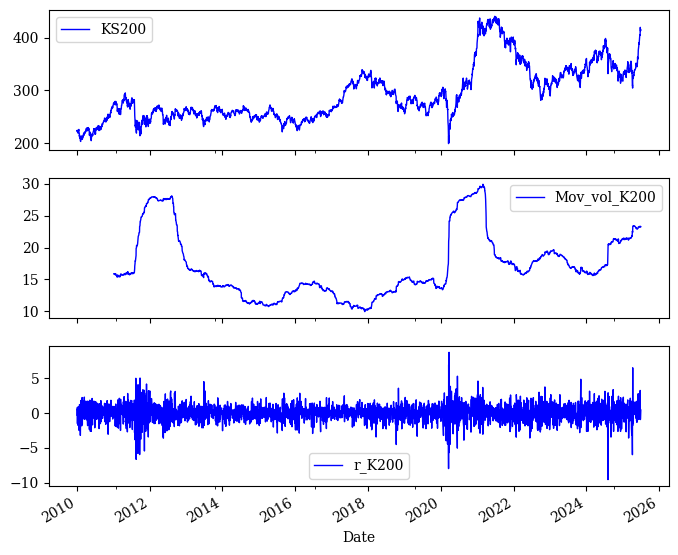

In [ ]:
eqt[['KS200','Mov_vol_K200', 'r_K200']].plot(subplots=True, style='b', lw='1', figsize=(8,7))

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

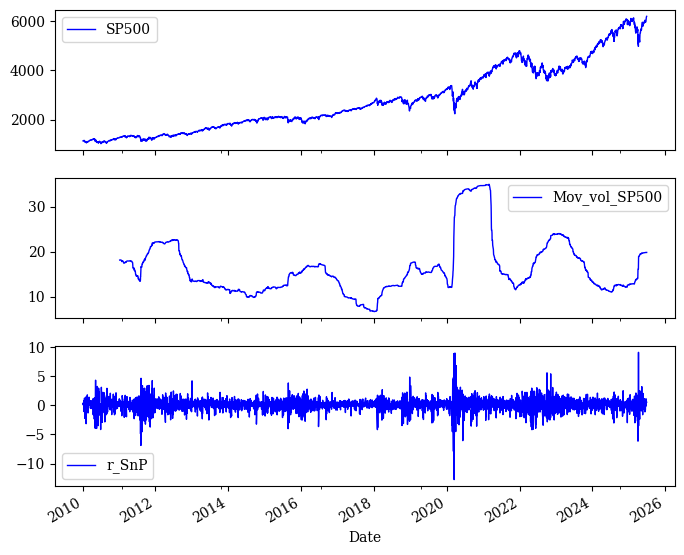

In [ ]:
eqt[['SP500','Mov_vol_SP500', 'r_SnP']].plot(subplots=True, style='b', lw='1', figsize=(8,7))

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

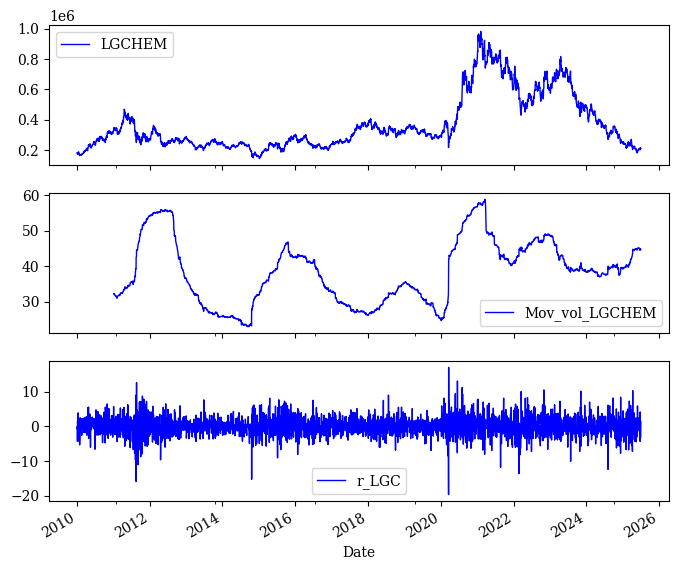

In [ ]:
eqt[['LGCHEM','Mov_vol_LGCHEM', 'r_LGC']].plot(subplots=True, style='b', lw='1', figsize=(8,7))

In [ ]:
pr = eqt[['KS200','SP500','LGCHEM']]
pr.head()

,KS200,SP500,LGCHEM
Date,,,
2010-01-04,223.490005,1132.989990,183289.593750
2010-01-05,222.839996,1136.520020,182062.203125
2010-01-06,224.669998,1137.140015,182062.203125
2010-01-07,221.309998,1141.689941,174288.765625
2010-01-08,222.660004,1144.979980,176743.546875


In [ ]:
print(pr.describe())
print('skeness: ', pr.skew(axis=0))
print('kurtosis: ', pr.kurtosis(axis=0))

             KS200        SP500         LGCHEM
count  3673.000000  3673.000000    3673.000000
mean    292.309954  2822.093335  367901.061402
std      52.069149  1353.105436  178430.525895
min     199.279999  1022.580017  144435.750000
25%     252.729996  1774.199951  244903.062500
50%     274.549988  2476.830078  302677.968750
75%     325.630005  3932.590088  419258.031250
max     440.399994  6204.950195  981677.937500
skeness:  KS200     0.882965
SP500     0.678554
LGCHEM    1.337231
dtype: float64
kurtosis:  KS200     0.076642
SP500    -0.554830
LGCHEM    0.771634
dtype: float64


In [ ]:
pr.corr()

,KS200,SP500,LGCHEM
KS200,1.000000,0.819574,0.766532
SP500,0.819574,1.000000,0.531789
LGCHEM,0.766532,0.531789,1.000000


In [ ]:
rt = eqt[['r_K200','r_SnP', 'r_LGC']]
rt.head()

,r_K200,r_SnP,r_LGC
Date,,,
2010-01-04,NaN,NaN,NaN
2010-01-05,-0.291269,0.311083,-0.671898
2010-01-06,0.817864,0.054537,0.000000
2010-01-07,-1.506823,0.399322,-4.363491
2010-01-08,0.608154,0.287758,1.398630


In [ ]:
rt.corr()

,r_K200,r_SnP,r_LGC
r_K200,1.000000,0.230648,0.578749
r_SnP,0.230648,1.000000,0.120537
r_LGC,0.578749,0.120537,1.000000


In [ ]:
n=10000; r=0.0325
x_vol=0.1981; y_vol=0.2121; z_vol=0.3877
n0=date.toordinal(date(2024, 6, 20))  # 최초 기준가격 결정일
n1=date.toordinal(date(2024, 12, 17))  # 1차 조기 상환일
n2=date.toordinal(date(2025, 6, 17))  # 2차 조기 상환일
n3=date.toordinal(date(2025 , 12, 16))  # 3차 조기 상환일
n4=date.toordinal(date(2026, 6, 16))  # 4차 조기 상환일
n5=date.toordinal(date(2026, 6, 16))  # 5차 조기 상환일
n6=date.toordinal(date(2027, 6, 15))  # 만기 상환일
check_day=np.array([n1-n0, n2-n0, n3-n0, n4-n0, n5-n0, n6-n0])
rho_xy=0.2745; rho_xz=0.189; rho_yz=0.6083  # 상관계수
corr=np.array([[1, rho_xy, rho_xz], [rho_xy, 1, rho_yz], [rho_xz, rho_yz, 1]])
k=np.linalg.cholesky(corr)
oneyear=365; tot_date=n6-n0; dt=1/oneyear
S1=np.zeros((tot_date+1, 1))
S2=np.zeros((tot_date+1, 1))
S3=np.zeros((tot_date+1, 1))
S1[0]=100.0; S2[0]=100.0; S3[0]=100.0
ratio_S1=S1[0]; ratio_S2=S2[0]; ratio_S3=S3[0]
strike_price=np.array([0.90, 0.90, 0.85, 0.85, 0.80, 0.75])  # 조기 행사가격
repay_n=len(strike_price) # 조기상환 횟수
coupon_rate=np.array([0.079, 0.158, 0.237, 0.316, 0.395, 0.474])  # 조기 상환시 쿠폰 이자율
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가
payment=np.zeros([repay_n, 1])
facevalue=10**4  # 액면금액
kib=0.5; dummy=0.474  # 낙인 배리어, 더미 이자율
early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수
for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [ ]:
for i in range(n):
    w0=np.random.normal(0, 1, size=[tot_date, 3])  # 만기상환일 만큼의 난수 생성
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    payoff=np.zeros([repay_n, 1]); repay_event=0
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0, j])  #
        S2[j+1]=S2[j]*np.exp((r-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1, j])  #
        S3[j+1]=S3[j]*np.exp((r-0.5*z_vol**2)*dt+z_vol*np.sqrt(dt)*w[2, j])  #
    R1=S1/ratio_S1; R2=S2/ratio_S2; R3=S3/ratio_S3
    WP=np.minimum(R1, R2, R3)
    WP_checkday=WP[check_day]

    for j in range(repay_n):
        if WP_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(WP) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*WP[-1]
           lose_count += 1
    tot_payoff=tot_payoff + payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

10890.958301647606


In [ ]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 6273, 발생빈도 : 62.73 %
2차 : 923, 발생빈도 : 9.23 %
3차 : 710, 발생빈도 : 7.10 %
4차 : 306, 발생빈도 : 3.06 %
5차 : 188, 발생빈도 : 1.88 %
6차 : 453, 발생빈도 : 4.53 %
만기상환 발생횟수 : 686, 발생빈도 : 6.86 %
만기손실 발생횟수 : 461, 발생빈도 : 4.61 %


/tmp/ipython-input-67-2353948544.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


#### Jump Diffusion Model

In [ ]:
lamb = 1.4
mu1 = -0.05
mu2 = -0.07
mu3 = -0.09
delta = 0.15

In [ ]:
rj1 = lamb * (math.exp(mu1 + 0.5 * delta ** 2) - 1)
rj2 = lamb * (math.exp(mu2 + 0.5 * delta ** 2) - 1)
rj3 = lamb * (math.exp(mu3 + 0.5 * delta ** 2) - 1)

In [ ]:
dt=1/oneyear
S1=np.zeros([tot_date+1, 1])
S2=np.zeros([tot_date+1, 1])
S3=np.zeros((tot_date+1, 1))
S1[0]=100.0; S2[0]=100.0; S3[0]=100.0

early_count = np.zeros([repay_n, 1]) # 각 조기상환기간 충족횟수
maturity_count = 0 # 만기상환 발생횟수
lose_count = 0 # 만기손실 발생횟수

payment=np.zeros([repay_n, 1])
facevalue=10000  # 액면금액
tot_payoff=np.zeros([repay_n, 1])  # 전체 페이오프
payoff=np.zeros([repay_n, 1])  # 페이오프
discount_payoff=np.zeros([repay_n, 1])  # 페이오프의 현가

for j in range(repay_n):
    payment[j]=facevalue*(1+coupon_rate[j])

In [ ]:
for i in range(n):
    w0=np.random.normal(0, 1, size=[tot_date, 3])  # 만기상환일 만큼의 난수 생성
    w0=np.transpose(w0)
    w=np.matmul(k, w0)
    payoff=np.zeros([repay_n, 1]); repay_event=0
    sn11 = npr.standard_normal(tot_date)
    poi1 = npr.poisson(lamb * dt, tot_date)
    sn12 = npr.standard_normal(tot_date)
    poi2 = npr.poisson(lamb * dt, tot_date)
    sn13 = npr.standard_normal(tot_date)
    poi3 = npr.poisson(lamb * dt, tot_date)
    for j in range(tot_date):
        S1[j+1]=S1[j]*np.exp((r-rj1-0.5*x_vol**2)*dt+x_vol*np.sqrt(dt)*w[0, j]+(np.exp(mu1 + delta * sn11[j]) - 1) * poi1[j])  #
        S2[j+1]=S2[j]*np.exp((r-rj2-0.5*y_vol**2)*dt+y_vol*np.sqrt(dt)*w[1, j]+(np.exp(mu2 + delta * sn12[j]) - 1) * poi2[j])  #
        S3[j+1]=S3[j]*np.exp((r-rj3-0.5*z_vol**2)*dt+z_vol*np.sqrt(dt)*w[2, j]+(np.exp(mu3 + delta * sn13[j]) - 1) * poi3[j])  #
    R1=S1/ratio_S1; R2=S2/ratio_S2; R3=S3/ratio_S3
    WP=np.minimum(R1, R2, R3)
    WP_checkday=WP[check_day]

    for j in range(repay_n):
        if WP_checkday[j] >= strike_price[j]:  # 조기상환일에 주가를 체크, 조기 상환여부 결정
            payoff[j]=payment[j]
            early_count[j] += 1
            repay_event=1
            break
    if repay_event == 0:  # 조기상환 되지 않고 만기까지 온 경우
       if min(WP) > kib:  # 낙인 배리어 아래로 내려간 적이 없는 경우
           payoff[-1]=facevalue*(1+dummy)
           maturity_count += 1
       else:  # 낙인 배리어 아래로 내려간 적이 있는 경우
           payoff[-1]=facevalue*WP[-1]
           lose_count += 1
    tot_payoff=tot_payoff + payoff
mean_payoff=tot_payoff/n
for j in range(repay_n):  # 페이오프를 무위험 이자율로 할인하여 현재 가격을 구함
    discount_payoff[j]=mean_payoff[j]*np.exp(-r*check_day[j]/oneyear)
price=np.sum(discount_payoff)
print(price)

10323.8154279564


In [ ]:
print('총 시뮬레이션 횟수 : %d' % (n))
print('조기상환 발생횟수')
for j in range(repay_n):
    print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")

print('만기상환 발생횟수 : %d, 발생빈도 : %.2f' % (maturity_count, (maturity_count)/n*100), "%")
print('만기손실 발생횟수 : %d, 발생빈도 : %.2f' % (lose_count, (lose_count/n)*100), "%")

총 시뮬레이션 횟수 : 10000
조기상환 발생횟수
1차 : 5557, 발생빈도 : 55.57 %
2차 : 928, 발생빈도 : 9.28 %
3차 : 746, 발생빈도 : 7.46 %
4차 : 368, 발생빈도 : 3.68 %
5차 : 178, 발생빈도 : 1.78 %
6차 : 437, 발생빈도 : 4.37 %
만기상환 발생횟수 : 510, 발생빈도 : 5.10 %
만기손실 발생횟수 : 1276, 발생빈도 : 12.76 %


/tmp/ipython-input-72-2353948544.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d차 : %d, 발생빈도 : %.2f' % (j+1, early_count[j], early_count[j]/n*100),"%")


#### FDM

In [ ]:
def thomas(alpha, beta, gamma, f):
    n=len(f)
    v=np.zeros(n)
    [aa, dd, cc, bb]=map(np.array,[alpha, beta, gamma, f])
    for i in range(1, n):
        mult=aa[i]/dd[i-1]
        dd[i]=dd[i]-mult*cc[i-1]
        bb[i]=bb[i]-mult*bb[i-1]
    v[n-1]=bb[n-1]/dd[n-1]
    for i in range(n-2, -1, -1):
        v[i]=(bb[i]-cc[i]*v[i+1])/dd[i]
    return v

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

facevalue=10000;
x_volatility=0.1981; y_volatility=0.2121; z_volatility=0.3877 # 각각의 변동성
rho_xy=0.2745; rho_yz=0.189; rho_zx=0.6083; # 상관계수
r=0.0325;  # 무위험 이자율
T=3; # 만기
x0=100; y0=100; z0=100;  # 최초 기준가격
# 조기상환시 쿠폰 이자율
coupon_rate=np.array([0.474, 0.395, 0.316, 0.237, 0.158, 0.079])
# 조기행사가
strike_price=np.array([0.75, 0.80, 0.85, 0.85, 0.90, 0.90])
dummy=0.474; kib=0.50; # 더미 이자율, 낙인 배리어

In [ ]:
Nt=360*T; dt=T/Nt; # 시간격자 갯수, 시간격자 간격
A=np.array([0]); B=np.arange(65,132.5,2.5); C=np.array([160,180,200,220]);
x=np.r_[A,B,C]; y=x; z=x;
# x, y, z벡터의 크기
Nx=len(x); Ny=Nx; Nz=Nx;
hx=np.diff(x); hy=hx; hz=hx;
step=np.arange(1,8,1)*Nt/6
lst=[Nx,Ny,Nz]
[u,ku]=map(np.zeros,[lst,lst])
# 유한차분법으로 ELS 가격을 구하기 위한 초기값
for i in range(0,Nx):
    for j in range(0,Ny):
        for k in range(0,Nz):
            if (x[i]<=kib*x0 or y[j]<=kib*y0 or z[k]<=kib*z0):
                u[i,j,k]=np.min([x[i],y[j],z[k]])/x0*facevalue
                ku[i,j,k]=np.min([x[i],y[j],z[k]])/x0*facevalue
            elif (x[i]<strike_price[0]*x0 or y[j]<strike_price[0]*y0 or z[k]<strike_price[0]*z0):
                u[i,j,k]=facevalue*(1.0+dummy)
                ku[i,j,k]=np.min([x[i],y[j],z[k]])/x0*facevalue
            else:
                u[i,j,k]=facevalue*(1+coupon_rate[0])
                ku[i,j,k]=facevalue*(1+coupon_rate[0])
# 유한차분법을 사용하기 위한 계수
[ax,dx,cx,ay,dy,cy,az,dz,cz]=map(np.zeros,[Nx-2,Nx-2,Nx-2,Ny-2,Ny-2,Ny-2,Nz-2,Nz-2,Nz-2])
ax[:]=(-(x_volatility*x[1:Nx-1])**2+r*x[1:Nx-1]*hx[1:Nx-1])/(hx[0:Nx-2]*(hx[0:Nx-2]+hx[1:Nx-1]))
dx[:]=1/dt+(x_volatility*x[1:Nx-1])**2/(hx[0:Nx-2]*hx[1:Nx-1])-r*x[1:Nx-1]*(hx[1:Nx-1]-hx[0:Nx-2])/(hx[0:Nx-2]*hx[1:Nx-1])+r/3
cx[:]=-((x_volatility*x[1:Nx-1])**2+r*x[1:Nx-1]*hx[0:Nx-2])/(hx[1:Nx-1]*(hx[0:Nx-2]+hx[1:Nx-1]))
# 선형 경계조건
ax[Nx-3]=ax[Nx-3]-cx[Nx-3]
dx[Nx-3]=dx[Nx-3]+2*cx[Nx-3]
ay[:]=(-(y_volatility*y[1:Ny-1])**2+r*y[1:Ny-1]*hy[1:Ny-1])/(hy[0:Ny-2]*(hy[0:Ny-2]+hy[1:Ny-1]))
dy[:]=1/dt+(y_volatility*y[1:Ny-1])**2/(hy[0:Ny-2]*hy[1:Ny-1])-r*y[1:Ny-1]*(hy[1:Ny-1]-hy[0:Ny-2])/(hy[0:Ny-2]*hy[1:Ny-1])+r/3
cy[:]=-((y_volatility*y[1:Ny-1])**2+r*y[1:Ny-1]*hy[0:Ny-2])/(hy[1:Ny-1]*(hy[0:Ny-2]+hy[1:Ny-1]))
ay[Ny-3]=ay[Ny-3]-cy[Ny-3]
dy[Ny-3]=dy[Ny-3]+2*cy[Ny-3]
az[:]=(-(z_volatility*z[1:Nz-1])**2+r*z[1:Nz-1]*hz[1:Nz-1])/(hz[0:Nz-2]*(hz[0:Nz-2]+hz[1:Nz-1]))
dz[:]=1/dt+(z_volatility*z[1:Nz-1])**2/(hz[0:Nz-2]*hz[1:Nz-1])-r*z[1:Nz-1]*(hz[1:Nz-1]-hz[0:Nz-2])/(hz[0:Nz-2]*hz[1:Nz-1])+r/3
cz[:]=-((z_volatility*z[1:Nz-1])**2+r*z[1:Nz-1]*hz[0:Nz-2])/(hz[1:Nz-1]*(hz[0:Nz-2]+hz[1:Nz-1]))
az[Nz-3]=az[Nz-3]-cz[Nz-3]
dz[Nz-3]=dz[Nz-3]+2*cz[Nz-3]
# OS방법을 사용하기 위해 u, ku와 같은 초기의 행렬 생성
[old_u,old_ku]=map(np.zeros,[lst,lst])
[fx,fy,fz]=map(np.zeros,[Nx-2,Nx-2,Nx-2])
tag=0

for iter in range(0,Nt):
    # 조기상환일의 페이오프
    if iter==step[tag]:
        gx=np.min(np.where(x>=x0*strike_price[tag+1]))
        gy=np.min(np.where(y>=y0*strike_price[tag+1]))
        gz=np.min(np.where(z>=z0*strike_price[tag+1]))
        u[gx:Nx,gy:Ny,gz:Nz]=facevalue*(1+coupon_rate[tag+1])
        ku[gx:Nx,gy:Ny,gz:Nz]=facevalue*(1+coupon_rate[tag+1])
        tag += 1
    gx=np.min(np.where(x>=x0*kib))
    gy=np.min(np.where(y>=y0*kib))
    gz=np.min(np.where(z>=z0*kib))
    u[0:gx+1,:,:]=ku[0:gx+1,:,:];
    u[:,0:gy+1,:]=ku[:,0:gy+1,:];
    u[:,:,0:gz+1]=ku[:,:,0:gz+1]
    # OSM과 토마스 알고리즘을 이용하여 u값 계산
    # x축으로 풀기
    for j in range(1,Ny-1):
        for k in range(1,Nz-1):
            fx[0:Nx-1]=1/3*rho_xy*x_volatility\
              *y_volatility*x[1:Nx-1]*y[j]\
              *(u[2:Nx,j+1,k]-u[2:Nx,j-1,k]\
              -u[0:Nx-2,j+1,k]+u[0:Nx-2,j-1,k])\
              /(hx[0:Nx-2]*hy[j]+hx[1:Nx-1]\
              *hy[j]+hx[1:Nx-1]*hy[j-1]+hx[0:Nx-2]\
              *hy[j-1])+1/3*rho_zx*x_volatility\
              *z_volatility*x[1:Nx-1]*z[k]\
              *(u[2:Nx,j,k+1]-u[2:Nx,j,k-1]\
              -u[0:Nx-2,j,k+1]+u[0:Nx-2,j,k-1])\
              /(hx[0:Nx-2]*hz[k]+hx[1:Nx-1]*hz[k]\
              +hx[1:Nx-1]*hz[k-1]+hx[0:Nx-2]*hz[k-1])\
              +1/3*rho_yz*y_volatility*z_volatility\
              *y[j]*z[k]*(u[1:Nx-1,j+1,k+1]\
              -u[1:Nx-1,j+1,k-1]-u[1:Nx-1,j-1,k+1]\
              +u[1:Nx-1,j-1,k-1])/(hy[j-1]*hz[k]\
              +hy[j]*hz[k]+hy[j]*hz[k-1])+hy[j-1]\
              *hz[k-1]+u[1:Nx-1,j,k]/dt
            old_u[1:Nx-1,j,k]=thomas(ax,dx,cx,fx)
    old_u[1:Nx-1,1:Ny-1,Nz-1]=2*old_u[1:Nx-1,1:Ny-1,Nz-2]-old_u[1:Nx-1,1:Ny-1,Nz-3]
    old_u[Nx-1,1:Ny-1,1:Nz]=2*old_u[Nx-2,1:Ny-1,1:Nz]-old_u[Nx-3,1:Ny-1,1:Nz]
    old_u[1:Nx,Ny-1,1:Nz]=2*old_u[1:Nx,Ny-2,1:Nz]-old_u[1:Nx,Ny-3,1:Nz]
    # y축으로 풀기
    for k in range(1,Nz-1):
        for i in range(1,Nx-1):
            fy[0:Ny-1]=1/3*rho_xy*x_volatility\
              *y_volatility*x[i]*y[1:Ny-1]\
              *(old_u[i+1,2:Ny,k]-old_u[i+1\
              ,0:Ny-2,k]-old_u[i-1,2:Ny,k]\
              +old_u[i-1,0:Ny-2,k])/(hx[i-1]\
              *hy[1:Ny-1]+hx[i]*hy[1:Ny-1]\
              +hx[i]*hy[0:Ny-2]+hx[i-1]\
              *hy[0:Ny-2])+1/3*rho_zx\
              *x_volatility*z_volatility\
              *x[i]*z[k]*(old_u[i+1,1:Ny-1,k+1]\
              -old_u[i+1,1:Ny-1,k-1]-old_u[i-1\
              ,1:Ny-1,k+1]+old_u[i-1,1:Ny-1,k-1])\
              /(hx[i-1]*hz[k]+hx[i]*hz[k]\
              +hx[i]*hz[k-1]+hx[i-1]*hz[k-1])\
              +1/3*rho_yz*y_volatility\
              *z_volatility*y[1:Ny-1]*z[k]\
              *(old_u[i,2:Ny,k+1]-old_u[i,2:Ny,k-1]\
              -old_u[i,0:Ny-2,k+1]+old_u[i,0:Ny-2\
              ,k-1])/(hy[0:Ny-2]*hz[k]+hy[1:Ny-1]\
              *hz[k]+hy[1:Ny-1]*hz[k-1]+hy[0:Ny-2]\
              *hz[k-1])+old_u[i,1:Ny-1,k]/dt
            u[i,1:Ny-1,k]=thomas(ay,dy,cy,fy)
    u[1:Nx-1,1:Ny-1,Nz-1]=2*u[1:Nx-1,1:Ny-1,Nz-2]-u[1:Nx-1,1:Ny-1,Nz-3]
    u[Nx-1,1:Ny-1,1:Nz]=2*u[Nx-2,1:Ny-1,1:Nz]-u[Nx-3,1:Ny-1,1:Nz]
    u[1:Nx,Ny-1,1:Nz]=2*u[1:Nx,Ny-2,1:Nz]-u[1:Nx,Ny-3,1:Nz]
    # z 축으로 풀기
    for j in range(1,Ny-1):
        for i in range(1,Nx-1):
            fz[0:Nz-1]=1/3*rho_xy*x_volatility\
              *y_volatility*x[i]*y[j]\
              *(u[i+1,j+1,1:Nz-1]-u[i+1,j-1,1:Nz-1]\
              -u[i-1,j+1,1:Nz-1]+u[i-1,j-1,1:Nz-1])\
              /(hx[i-1]*hy[j]+hx[i]*hy[j]+hx[i]\
              *hy[j-1]+hx[i-1]*hy[j-1])+1/3*rho_zx\
              *x_volatility*z_volatility*x[i]\
              *z[1:Nz-1]*(u[i+1,j,2:Nz]-u[i+1,j,0:Nz-2]-u[i-1,j,2:Nz]\
              +u[i-1,j,0:Nz-2])/(hx[i-1]*hz[1:Nz-1]\
              +hx[i]*hz[1:Nz-1]+hx[i]*hz[0:Nz-2]\
              +hx[i-1]*hz[0:Nz-2])+1/3*rho_yz\
              *y_volatility*z_volatility*y[j]*z[1:Nz-1]*(u[i,j+1,2:Nz]\
              -u[i,j+1,0:Nz-2]-u[i,j-1,2:Nz]+u[i,j-1,0:Nz-2])/(hy[j-1]\
              *hz[1:Nz-1]+hy[j]*hz[1:Nz-1]\
              +hy[j]*hz[0:Nz-2]+hy[j-1]*hz[0:Nz-2])\
              +u[i,j,1:Nz-1]/dt
            old_u[i,j,1:Nz-1]=thomas(az,dz,cz,fz)
    old_u[1:Nx-1,1:Ny-1,Nz-1]=2*old_u[1:Nx-1,1:Ny-1,Nz-2]-old_u[1:Nx-1,1:Ny-1,Nz-3]
    old_u[Nx-1,1:Ny-1,1:Nz]=2*old_u[Nx-2,1:Ny-1,1:Nz]-old_u[Nx-3,1:Ny-1,1:Nz]
    old_u[1:Nx,Ny-1,1:Nz]=2*old_u[1:Nx,Ny-2,1:Nz]-old_u[1:Nx,Ny-3,1:Nz]
    u=old_u

    # OSM과 토마스 알고리즘을 이용하여 ku값 계산
    # x 축으로 풀기
    for j in range(1,Ny-1):
        for k in range(1,Nz-1):
            fx[0:Nx-1]=1/3*rho_xy*x_volatility\
              *y_volatility*x[1:Nx-1]*y[j]\
              *(ku[2:Nx,j+1,k]-ku[2:Nx,j-1,k]\
              -ku[0:Nx-2,j+1,k]+ku[0:Nx-2,j-1,k])\
              /(hx[0:Nx-2]*hy[j]+hx[1:Nx-1]*hy[j]\
              +hx[1:Nx-1]*hy[j-1]+hx[0:Nx-2]*hy[j-1])\
              +1/3*rho_zx*x_volatility*z_volatility\
              *x[1:Nx-1]*z[k]*(ku[2:Nx,j,k+1]\
              -ku[2:Nx,j,k-1]-ku[0:Nx-2,j,k+1]\
              +ku[0:Nx-2,j,k-1])/(hx[0:Nx-2]*hz[k]\
              +hx[1:Nx-1]*hz[k]+hx[1:Nx-1]*hz[k-1]\
              +hx[0:Nx-2]*hz[k-1])+1/3*rho_yz\
              *y_volatility*z_volatility*y[j]\
              *z[k]*(ku[1:Nx-1,j+1,k+1]\
              -ku[1:Nx-1,j+1,k-1]-ku[1:Nx-1,j-1,k+1]\
              +ku[1:Nx-1,j-1,k-1])/(hy[j-1]*hz[k]\
              +hy[j]*hz[k]+hy[j]*hz[k-1]+hy[j-1]\
              *hz[k-1])+ku[1:Nx-1,j,k]/dt
            old_ku[1:Nx-1,j,k]=thomas(ax,dx,cx,fx)
    old_ku[1:Nx-1,1:Ny-1,Nz-1]=2*old_ku[1:Nx-1,1:Ny-1,Nz-2]-old_ku[1:Nx-1,1:Ny-1,Nz-3]
    old_ku[Nx-1,1:Ny-1,1:Nz]=2*old_ku[Nx-2,1:Ny-1,1:Nz]-old_ku[Nx-3,1:Ny-1,1:Nz]
    old_ku[1:Nx,Ny-1,1:Nz]=2*old_ku[1:Nx,Ny-2,1:Nz]-old_ku[1:Nx,Ny-3,1:Nz]
    # y 축으로 풀기
    for k in range(1,Nz-1):
        for i in range(1,Nx-1):
             fy[0:Ny-1]=1/3*rho_xy*x_volatility\
              *y_volatility*x[i]*y[1:Ny-1]\
              *(old_ku[i+1,2:Ny,k]-old_ku[i+1,0:Ny-2,\
              k]-old_ku[i-1,2:Ny,k]+old_ku[i-1,0:Ny-2,k])/(hx[i-1]\
              *hy[1:Ny-1]+hx[i]*hy[1:Ny-1]+hx[i]\
              *hy[0:Ny-2]+hx[i-1]*hy[0:Ny-2])+1/3\
              *rho_zx*x_volatility*z_volatility\
              *x[i]*z[k]*(old_ku[i+1,1:Ny-1,k+1]\
              -old_ku[i+1,1:Ny-1,k-1]-old_ku[i-1,\
              1:Ny-1,k+1]+old_ku[i-1,1:Ny-1,k-1])/\
              (hx[i-1]*hz[k]+hx[i]*hz[k]+hx[i]*hz[k-1]\
              +hx[i-1]*hz[k-1])+1/3*rho_yz*\
              y_volatility*z_volatility*y[1:Ny-1]*z[k]\
              *(old_ku[i,2:Ny,k+1]-old_ku[i,2:Ny,k-1]\
              -old_ku[i,0:Ny-2,k+1]+old_ku[i,0:Ny-2\
              ,k-1])/(hy[0:Ny-2]*hz[k]+hy[1:Ny-1]\
              *hz[k]+hy[1:Ny-1]*hz[k-1]+hy[0:Ny-2]\
              *hz[k-1])+old_ku[i,1:Ny-1,k]/dt
             ku[i,1:Ny-1,k]=thomas(ay,dy,cy,fy)
    ku[1:Nx-1,1:Ny-1,Nz-1]=2*ku[1:Nx-1,1:Ny-1,Nz-2]-ku[1:Nx-1,1:Ny-1,Nz-3]
    ku[Nx-1,1:Ny-1,1:Nz]=2*ku[Nx-2,1:Ny-1,1:Nz]-ku[Nx-3,1:Ny-1,1:Nz]
    ku[1:Nx,Ny-1,1:Nz]=2*ku[1:Nx,Ny-2,1:Nz]-ku[1:Nx,Ny-3,1:Nz]
    # z 축으로 풀기
    for j in range(1,Ny-1):
        for i in range(1,Nx-1):
            fz[0:Nz-1]=1/3*rho_xy*x_volatility\
              *y_volatility*x[i]*y[j]*(ku[i+1,j+1,1:Nz-1]\
              -ku[i+1,j-1,1:Nz-1]-ku[i-1,j+1,1:Nz-1]\
              +ku[i-1,j-1,1:Nz-1])/(hx[i-1]\
              *hy[j]+hx[i]*hy[j]+hx[i]*hy[j-1]\
              +hx[i-1]*hy[j-1])+1/3*rho_zx\
              *x_volatility*z_volatility*x[i]\
              *z[1:Nz-1]*(ku[i+1,j,2:Nz]\
              -ku[i+1,j,0:Nz-2]-ku[i-1,j,2:Nz]\
              +ku[i-1,j,0:Nz-2])/(hx[i-1]\
              *hz[1:Nz-1]+hx[i]*hz[1:Nz-1]\
              +hx[i]*hz[0:Nz-2]+hx[i-1]\
              *hz[0:Nz-2])+1/3*rho_yz\
              *y_volatility*z_volatility*y[j]\
              *z[1:Nz-1]*(ku[i,j+1,2:Nz]\
              -ku[i,j+1,0:Nz-2]-ku[i,j-1,2:Nz]\
              +ku[i,j-1,0:Nz-2])/(hy[j-1]\
              *hz[1:Nz-1]+hy[j]*hz[1:Nz-1]\
              +hy[j]*hz[0:Nz-2]+hy[j-1]\
              *hz[0:Nz-2])+ku[i,j,1:Nz-1]/dt
            old_ku[i,j,1:Nz-1]=thomas(az,dz,cz,fz)
    old_ku[1:Nx-1,1:Ny-1,Nz-1]=2*old_ku[1:Nx-1,1:Ny-1,Nz-2]-old_ku[1:Nx-1,1:Ny-1,Nz-3]
    old_ku[Nx-1,1:Ny-1,1:Nz]=2*old_ku[Nx-2,1:Ny-1,1:Nz]-old_ku[Nx-3,1:Ny-1,1:Nz]
    old_ku[1:Nx,Ny-1,1:Nz]=2*old_ku[1:Nx,Ny-2,1:Nz]-old_ku[1:Nx,Ny-3,1:Nz]
    ku=old_ku

ii=np.where(x==100)
jj=np.where(y==100)
kk=np.where(z==100)
print('Price=%f'%(u[ii,jj,kk]))

Price=9441.589971


/tmp/ipython-input-75-3960689565.py:223: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Price=%f'%(u[ii,jj,kk]))
